In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import collect as clct
import db_operations as dbop


def _check_int(arg):
    if type(arg) != int:
        raise ValueError("{} is not a int".format(arg))


def _check_iterable(arg):
    if not hasattr(arg, "__iter__"):
        raise ValueError("{} is not iterable".format(arg))


def _make_iterable(arg):
    if type(arg) == str or not hasattr(arg, "__iter__"):
        return [arg]
    else:
        return arg


def _prefix(prefix, df: pd.DataFrame, copy=False):
    if copy:
        df = df.copy()
    df.columns = list(map(lambda col: str(prefix) + "_" + col, df.columns))
    return df


def _move(days, df: pd.DataFrame, cols=None, prefix=True):
    _check_int(days)
    if cols is None:
        cols = df.columns
    cols = _make_iterable(cols)

    if days > 0:
        pre = "p{}mv".format(abs(days))
        df_mv = df[cols].iloc[days:].copy()
        df_mv.index = df.index[:-days]
    else:
        pre = "f{}mv".format(abs(days))
        df_mv = df[cols].iloc[:days].copy()
        df_mv.index = df.index[-days:]

    if prefix:
        return _prefix(pre, df_mv)
    else:
        return df_mv


def _rolling(rolling_type, days, df: pd.DataFrame, cols, move=0, has_prefix=True):
    _check_int(days)
    cols = _make_iterable(cols)

    period = abs(days)
    if rolling_type=="max":
        df_rolling = df[cols].rolling(window=abs(days)).max()
    elif rolling_type=="min":
        df_rolling = df[cols].rolling(window=abs(days)).min()
    elif rolling_type=="mean":
        df_rolling = df[cols].rolling(window=abs(days)).max()
    else:
        raise ValueError("rolling_type='{}' is not supported.".format(rolling_type))

    if move != 0:
        df_rolling = _move(move, df_rolling)
    n = len(df_rolling)
    idxes = df_rolling.index
    if days > 0:
        pre = "f" + str(abs(days)) + rolling_type
        df_rolling = df_rolling.iloc[period - 1:n]
        df_rolling.index = idxes[period - 1:n]
    else:
        pre = "p" + str(abs(days)) + rolling_type
        df_rolling = df_rolling.iloc[period - 1:n]
        if n - period + 1 >= 0:
            df_rolling.index = idxes[:n - period + 1]

    if has_prefix:
        return _prefix(pre, df_rolling)
    else:
        return df_rolling


def _rolling_max(days, df: pd.DataFrame, cols, move=0, has_prefix=True):
    _check_int(days)
    cols = _make_iterable(cols)

    period = abs(days)
    df_rolling = df[cols].rolling(window=abs(days)).max()
    if move!=0:
        # print("--------",move)
        # print(df_rolling[df["code"] == "600887.SH"]["high"].iloc[:30])
        df_rolling = _move(move, df_rolling)
        # print(df_rolling[df["code"] == "600887.SH"]["f1mv_high"].iloc[:30])
    n = len(df_rolling)
    idxes = df_rolling.index
    if days > 0:
        pre = "f" + str(abs(days)) + "max"
        df_rolling = df_rolling.iloc[period-1:n]
        df_rolling.index = idxes[period-1:n]
        # df_rolling = df_rolling.iloc[period-1:n+move]
        # df_rolling.index = df.index[period-1-move:n]
    else:
        pre= "p" + str(abs(days)) + "max"
        df_rolling = df_rolling.iloc[period-1:n]
        if n-period+1>=0:
            df_rolling.index = idxes[:n-period+1]

        # df_rolling = df_rolling.iloc[period-1+move:n]
        # df_rolling.index = df.index[:n-period+1-move]

    if has_prefix:
        return _prefix(pre,df_rolling)
    else:
        return df_rolling


def _rolling_min(days, df: pd.DataFrame, cols, move=0, has_prefix=True):
    _check_int(days)
    cols = _make_iterable(cols)

    period = abs(days)
    df_rolling = df[cols].rolling(window=abs(days)).min()
    if move != 0:
        # print("--------",move)
        # print(df_rolling[df["code"] == "600887.SH"]["high"].iloc[:30])
        df_rolling = _move(move, df_rolling)
        # print(df_rolling[df["code"] == "600887.SH"]["f1mv_high"].iloc[:30])
    n = len(df_rolling)
    idxes = df_rolling.index
    if days > 0:
        pre = "f" + str(abs(days)) + "min"
        df_rolling = df_rolling.iloc[period - 1:n]
        df_rolling.index = idxes[period - 1:n]
    else:
        pre = "p" + str(abs(days)) + "min"
        df_rolling = df_rolling.iloc[period - 1:n]
        if n-period+1>=0:
            df_rolling.index = idxes[:n-period+1]

    if has_prefix:
        return _prefix(pre,df_rolling)
    else:
        return df_rolling


def _rolling_mean(days, df: pd.DataFrame, cols, move=0, has_prefix=True):
    _check_int(days)
    cols = _make_iterable(cols)

    period = abs(days)
    df_rolling = df[cols].rolling(window=abs(days)).mean()
    if move != 0:
        df_rolling = _move(move, df_rolling)
    n = len(df_rolling)
    idxes = df_rolling.index
    if days > 0:
        pre = "f" + str(abs(days)) + "mean"
        df_rolling = df_rolling.iloc[period - 1:n]
        df_rolling.index = idxes[period - 1:n]
    else:
        pre = "p" + str(abs(days)) + "mean"
        df_rolling = df_rolling.iloc[period - 1:n]
        if n - period + 1 >= 0:
            df_rolling.index = idxes[:n - period + 1]

    if has_prefix:
        return _prefix(pre,df_rolling)
    else:
        return df_rolling


def change_rate(df1: pd.DataFrame, df2: pd.DataFrame, cols1=None, cols2 =None):
    if cols1:
        df1 = df1[cols1].copy()
    if cols2:
        df2 = df2[cols2].copy()
    
    if df1.shape[1] != df2.shape[1]:
        raise ValueError("Column length not the same:{0}!={1}".format(df1.shape[1], df2.shape[1]))

    df1 = df1.copy()
    df1.columns = df2.columns
    df3 = (df2 - df1) / df1
    df3 = _prefix("change_rate", df3)
    return df3


def create_df(cursor, table_name, start=None):
    if start:
        sql_select = "select * from {0} where date>={1}".format(table_name,start)
    else:
        sql_select = "select * from {0}".format(table_name)
    cursor.execute(sql_select)
    df = pd.DataFrame(cursor.fetchall())
    df.columns = dbop.cols_from_cur(cursor)
    return df


def prepare_stck_d(df_stck_d):
    df_stck_d = df_stck_d.set_index(["date"]).sort_index(ascending=False)
    df_stck_d = df_stck_d[["code", "open", "high", "low", "close", "vol", "amt", "adj_factor"]]
    return df_stck_d


def prepare_idx_d(df_idx_d):
    df_idx_d = df_idx_d.set_index("date").sort_index(ascending=False)
    return df_idx_d


def prepare_each_stck(df_stck):
    df_stck = df_stck.copy()
    qfq_cols = ["open", "high", "low", "close"]
    # qfq_factor = np.array(df_stck["adj_factor"] / df_stck["adj_factor"].iloc[0])
    # print(qfq_factor.shape)
    qfq_factor = np.array(df_stck["adj_factor"]).reshape(-1, 1) * np.ones((1,
                                                                  len(qfq_cols)))
    # print(df_stck[qfq_cols].dtypes)
    # print(qfq_factor.shape, qfq_factor.dtype)
    # print(df_stck[qfq_cols]/qfq_factor)
    df_stck.loc[:, qfq_cols] = df_stck[qfq_cols] * qfq_factor
    # print(qfq_factor[:30])
    return df_stck


def proc_stck_d(df_stck_d, pred_period = 10):
    df_stck_d = prepare_stck_d(df_stck_d)

    df_stck_list = []
    cols_move = ["open", "high", "low", "close", "amt"]
    cols_roll = ["open", "high", "low", "close", "amt"]
    cols_future = None
    for code, df in df_stck_d.groupby("code"):
        df = df.sort_index(ascending=False)
        df = prepare_each_stck(df)
        df_label_min = _rolling_min(pred_period, df, "low", move=-1)
        df_label_max = _rolling_max(pred_period-1, df, "high", move=-2)
        p1 = (pred_period-1)//3
        p2 = p1
        p3 = pred_period-1-p1-p2
        df_label_mean1 = _rolling_mean(p1,df,"open",move=-2)
        df_label_mean2 = _rolling_mean(p2,df,"open",move=-2-p1)
        df_label_mean3 = _rolling_mean(p3,df,"open",move=-2-p1-p2)

        # print(df_label_min.columns)
        df_tomorrow = _move(-1,df,["open","high","low","close"])
        
        # df_label_min = _rolling_min(pred_period,df,"low")

        # if code == "000002.SZ":
        #     tmp = _rolling_min(-5,df,cols_roll).loc["2018-08-07"]
        #     print(tmp)
        df_move_list = [change_rate(df[cols_move], _move(i, df, cols_move)) for i in range(1, 6)]
        df_rolling_list = [(change_rate(df[cols_roll], _rolling_max(i, df, cols_roll)),
                            change_rate(df[cols_roll], _rolling_min(i, df, cols_roll)),
                            change_rate(df[cols_roll], _rolling_mean(i, df, cols_roll)))
                           for i in [-5, -10, -20, -60, -120, -250]]

        df_roll_flat_list = []
        for df_rolling_group in df_rolling_list:
            df_roll_flat_list.extend(df_rolling_group)

        df_labels = pd.concat([df_tomorrow,
                               df_label_max,
                               df_label_min,
                               df_label_mean1,
                               df_label_mean2,
                               df_label_mean3], axis=1,sort=False)
        df_stck = pd.concat(
            [df] + df_move_list + df_roll_flat_list + [df_labels],
                        axis=1, sort=False)
        df_stck_list.append(df_stck)

        if not cols_future:
            cols_future = list(df_labels)
        # print(tmp.shape)
        # print(tmp[tmp[col_label].isnull()])
        if code == "002217.SZ":
            print(df[df.index=="2018-01-02"])
            print(df_stck[df_stck.index=="2018-01-02"])

    df_stck_d_all = pd.concat(df_stck_list, sort=False)
    for df in df_stck_list:
        print(df["code"].unique(),df.shape)
        print(df["code"].unique(),df[df.index>="2018-01-01"].shape)
    print("count stck",len(df_stck_d_all["code"][df_stck_d_all.index >= "2018-01-01"].unique()))
    print(df_stck_d_all.shape)

    return df_stck_d_all,cols_future


def proc_idx_d(df_idx_d: pd.DataFrame):
    df_idx_d = prepare_idx_d(df_idx_d)
    cols_move = ["open", "high", "low", "close", "vol"]
    cols_roll = cols_move

    df_idx_list = []
    for name, group in df_idx_d.groupby("code"):
        group = group.sort_index(ascending=False)
        del group["code"]
        df_move_list = [change_rate(group[cols_move], _move(i, group, cols_move)) for i in range(1, 6)]
        df_rolling_list = [(change_rate(group[["high","vol"]], _rolling_max(i, group, ["high","vol"])),
                            change_rate(group[["low","vol"]], _rolling_min(i, group, ["low","vol"])),
                            change_rate(group[["open","close","vol"]], _rolling_mean(i, group, ["open","close","vol"])))
                           for i in [-5, -10, -20,-60,-120,-250,-500]]

        df_roll_flat_list = []
        for df_rolling_group in df_rolling_list:
            df_roll_flat_list.extend(df_rolling_group)

        tmp_list = [group] + df_move_list + df_roll_flat_list
        tmp = pd.concat(tmp_list, axis=1, sort=False)
        df_idx_list.append(_prefix(name, tmp))

    df_idx_d = pd.concat(df_idx_list, axis=1, sort=False)
    return df_idx_d


def prepare_data(cursor, pred_period=10, start=None):
    stock_day, index_day = clct.STOCK_DAY[clct.TABLE], clct.INDEX_DAY[
        clct.TABLE]

    df_stck_d = create_df(cursor, stock_day,start)
    df_idx_d = create_df(cursor, index_day,start)

    df_stck_d_all,cols_future = proc_stck_d(df_stck_d,pred_period=pred_period)
    print(df_stck_d_all.shape)

    df_idx_d = proc_idx_d(df_idx_d)
    print(df_idx_d.shape,len(df_idx_d.index.unique()))
    df_all = df_stck_d_all.join(df_idx_d)
    print(df_all.shape)

    print(df_all[(df_all.index == "2018-01-02") & (df_all["code"]=="002217.SZ")])

    return df_all,cols_future


def y_distribution(y):
    y = y.copy().dropna()
    # print distribution of y
    print("before",sum(y<0))
    print("y<-0.5:", sum(y < -0.5))
    for i in range(-5, 5):
        tmp1 = ((i * 0.1) <= y)
        tmp2 = (y < ((i + 1) * 0.1))
        if len(tmp1) == 0 or len(tmp2) == 0:
            tmp = [False]
        else:
            tmp = tmp1 & tmp2
        print("{0:.2f}<=y<{1:.2f}:".format(i * 0.1, (i + 1) * 0.1),
              sum(tmp))
    print("y>0.5", sum(y > 0.5))
    print("after", sum(y < 0))
    plt.figure()
    plt.hist(y,bins=np.arange(-10, 11)*0.1)


def gen_y(df_all:pd.DataFrame, threshold=0.1, pred_period=10, 
          label_type="inc"):
    if label_type and (label_type not in ["inc","dec"]):
        raise ValueError("label_type {} is not supported!".format(label_type))
    
    y = (df_all["f{}max_f2mv_high".format(pred_period-1)] / df_all[
        "f1mv_open"] - 1)
    y_distribution(y)
    
    if label_type=="dec":
        y = -y
    
    if label_type:
        y[y > threshold] = 1
        y[y <= threshold] = 0
        print("过滤涨停前",sum(y==1))

    y[df_all["f1mv_high"]==df_all["f1mv_low"]] = 0
    
    if label_type:
        print("过滤涨停后",sum(y==1))

    return y


def feature_select(X,y):
    import sklearn.ensemble as ensemble
    clf = ensemble.ExtraTreesClassifier(random_state=0)
    clf.fit(X,y)
    import sklearn.feature_selection as fselect
    model = fselect.SelectFromModel(clf,prefit=True)
    X_new = model.transform(X)
    print("selected feature number:", X_new.shape)

    return X_new,model


def drop_null(X,y):
    Xy = np.concatenate((np.array(X), np.array(y).reshape(-1, 1)), axis=1)
    Xy = pd.DataFrame(Xy, index=X.index).dropna()
    X = Xy.iloc[:, :-1].copy()
    y = Xy.iloc[:, -1].copy()
    return X,y

                 code      open      high       low     close        vol  \
date                                                                       
2018-01-02  002217.SZ  56.11754  56.45492  55.55524  56.00508  191532.71   

                   amt  adj_factor  
date                                
2018-01-02  190581.978       5.623  
                 code      open      high       low     close        vol  \
2018-01-02  002217.SZ  56.11754  56.45492  55.55524  56.00508  191532.71   

                   amt  adj_factor  change_rate_p1mv_open  \
2018-01-02  190581.978       5.623               0.007014   

            change_rate_p1mv_high        ...          \
2018-01-02                0.00996        ...           

            change_rate_p250mean_amt  f1mv_open  f1mv_high  f1mv_low  \
2018-01-02                  0.063479   55.83639   58.14182  55.78016   

            f1mv_close  f19max_f2mv_high  f20min_f1mv_low  f6mean_f2mv_open  \
2018-01-02    57.80444          58.31051       

['000001.SZ'] (2370, 132)
['000001.SZ'] (182, 132)
['000002.SZ'] (2370, 132)
['000002.SZ'] (182, 132)
['000063.SZ'] (2370, 132)
['000063.SZ'] (182, 132)
['000070.SZ'] (2370, 132)
['000070.SZ'] (182, 132)
['000333.SZ'] (1227, 132)
['000333.SZ'] (182, 132)
['000636.SZ'] (2370, 132)
['000636.SZ'] (182, 132)
['000651.SZ'] (2370, 132)
['000651.SZ'] (182, 132)
['000725.SZ'] (2370, 132)
['000725.SZ'] (182, 132)
['000858.SZ'] (2370, 132)
['000858.SZ'] (182, 132)
['002027.SZ'] (2370, 132)
['002027.SZ'] (182, 132)
['002217.SZ'] (2370, 132)
['002217.SZ'] (182, 132)
['002236.SZ'] (2370, 132)
['002236.SZ'] (182, 132)
['002335.SZ'] (2119, 132)
['002335.SZ'] (182, 132)
['002359.SZ'] (2099, 132)
['002359.SZ'] (182, 132)
['002402.SZ'] (2042, 132)
['002402.SZ'] (182, 132)
['002415.SZ'] (2029, 132)
['002415.SZ'] (182, 132)
['002446.SZ'] (2000, 132)
['002446.SZ'] (182, 132)
['002913.SZ'] (203, 132)
['002913.SZ'] (182, 132)
['300038.SZ'] (2122, 132)
['300038.SZ'] (182, 132)
['300059.SZ'] (2077, 132)
['3000

(2126, 395) 2126


(76597, 527)


                 code      open      high       low     close        vol  \
2018-01-02  002217.SZ  56.11754  56.45492  55.55524  56.00508  191532.71   

                   amt  adj_factor  change_rate_p1mv_open  \
2018-01-02  190581.978       5.623               0.007014   

            change_rate_p1mv_high              ...                \
2018-01-02                0.00996              ...                 

            sz50_change_rate_p250mean_open  sz50_change_rate_p250mean_close  \
2018-01-02                       -0.108622                        -0.119734   

            sz50_change_rate_p250mean_vol  sz50_change_rate_p500max_high  \
2018-01-02                      -0.452498                       0.043269   

            sz50_change_rate_p500max_vol  sz50_change_rate_p500min_low  \
2018-01-02                       0.72266                     -0.340513   

            sz50_change_rate_p500min_vol  sz50_change_rate_p500mean_open  \
2018-01-02                       -0.8293          

2014-01-02   -0.012346
2014-01-02   -0.005019
2014-01-02    0.016703
2014-01-02    0.100000
2014-01-02    0.017769
2014-01-02    0.019928
2014-01-02   -0.018987
2014-01-02    0.037736
2014-01-02    0.007828
2014-01-02    0.685499
2014-01-02    0.267578
2014-01-02    0.014118
2014-01-02    0.173324
2014-01-02    0.099548
2014-01-02    0.275000
2014-01-02    0.020259
2014-01-02    0.158824
2014-01-02    0.329836
2014-01-02    0.141119
2014-01-02    0.237326
2014-01-02   -0.018634
2014-01-02    0.013825
2014-01-02   -0.002089
2014-01-02   -0.000466
2014-01-02    0.147944
2014-01-02    0.094288
2014-01-02    0.178862
2014-01-02    0.097378
2014-01-02    0.030395
2014-01-02    0.090612
                ...   
2018-08-29    0.072214
2018-08-29    0.016413
2018-08-29   -0.019108
2018-08-29    0.079975
2018-08-29   -0.008950
2018-08-29    0.007974
2018-08-29    0.000000
2018-08-29    0.012737
2018-08-29    0.020188
2018-08-29    0.039495
2018-08-29   -0.027422
2018-08-29   -0.006912
2018-08-29 

full and X (37369, 517) (37369, 527)
(37369, 517) (37369,)
total positive 9579.0
(5803, 517) (5803,)
test positive: 936.0
(5803, 527) (5803, 517)
(1, 527)


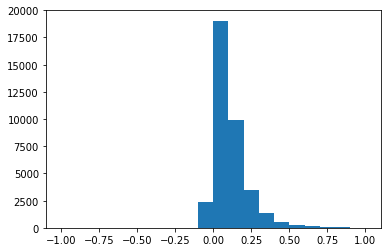

In [38]:
db_type = "sqlite3"

conn = dbop.connect_db(db_type)
cursor = conn.cursor()

pred_period = 20
df_all, cols_future = prepare_data(cursor, pred_period=pred_period, start="2011-01-01")

import xgboost.sklearn as xgb
import lightgbm.sklearn as lgbm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import time
import sklearn.preprocessing as preproc

period = (df_all.index >= "2014-01-01")
df_all = df_all[period]

df_all = df_all[df_all["amt"] != 0]

y = gen_y(df_all, threshold=0.15, pred_period=pred_period,label_type="inc")
print("null:", sum(y.isnull()))

features = df_all.columns.difference(cols_future + ["code"])

X = df_all[features]

# X,y = drop_null(X,y)
X = X[y.notnull()]
X_full = df_all[y.notnull()]
print("full and X", X.shape, X_full.shape)
y = y.dropna()
print(X.shape, y.shape)
print("total positive", sum(y))

condition = (X.index >= "2018-01-01")
X_train, y_train = X[~condition], y[~condition]
X_test, y_test = X[condition], y[condition]

print(X_test.shape, y_test.shape)
print("test positive:", sum(y_test))

X_train_full = X_full.loc[condition]
X_test_full = X_full.loc[condition]

print(X_test_full.shape, X_test.shape)
print(X_test_full[(X_test_full.index == "2018-01-02") & (X_test_full["code"] == "002217.SZ")].shape)

# print(X_test_full["code"].iloc[np.array(y_test == 1)])
# print(X_test_full[X_test_full["code"]=="002217.SZ"])

# # scaler = preproc.StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# # X_test = scaler.transform(X_test)
#
# # X_train,selector = feature_select(X_train,y_train)
# # X_test = selector.transform(X_test)
#
#
scale_pos_weight = sum(y == 0) / sum(y == 1)

[0. 1.]
(5803,) 280
2018-01-30    002446.SZ
2018-02-01    002446.SZ
2018-02-01    600487.SH
2018-02-01    600536.SH
2018-02-06    002446.SZ
2018-02-06    300679.SZ
2018-02-06    600536.SH
2018-02-07    002335.SZ
2018-02-07    002446.SZ
2018-02-07    300679.SZ
2018-02-07    600536.SH
2018-02-08    000002.SZ
2018-02-09    000002.SZ
2018-02-13    000002.SZ
2018-02-14    000002.SZ
2018-02-14    000858.SZ
2018-02-14    300679.SZ
2018-02-14    600519.SH
2018-02-22    000002.SZ
2018-02-27    000002.SZ
2018-02-28    000002.SZ
2018-02-28    000651.SZ
2018-02-28    000858.SZ
2018-02-28    002446.SZ
2018-02-28    600519.SH
2018-03-01    000002.SZ
2018-03-01    000651.SZ
2018-03-01    000858.SZ
2018-03-02    000002.SZ
2018-03-02    000651.SZ
                ...    
2018-08-17    300679.SZ
2018-08-17    600345.SH
2018-08-17    600536.SH
2018-08-17    603799.SH
2018-08-20    002236.SZ
2018-08-21    002236.SZ
2018-08-21    600779.SH
2018-08-22    000063.SZ
2018-08-22    002236.SZ
2018-08-22    600536

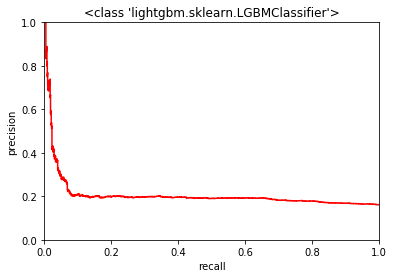

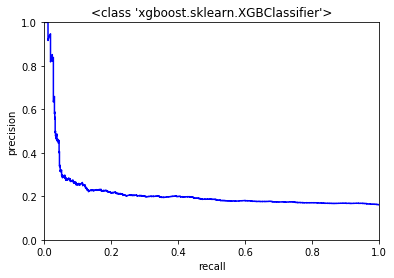

In [ ]:
clfs = [
    lgbm.LGBMClassifier(n_estimators=300, scale_pos_weight=0.1,
                        num_leaves=100, max_depth=8, random_state=0),
    xgb.XGBClassifier(n_estimators=300, scale_pos_weight=0.1,
                      max_depth=5,
                      random_state=0, ),
]

y_prd_list = []
colors = ["r", "b"]
for clf, c in zip(clfs, colors):
    t1 = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    y_prd_list.append([clf, t2 - t1, clf.predict_proba(X_test), c])


[0. 1.]
(5803,) 280
2018-01-30    002446.SZ
2018-02-01    002446.SZ
2018-02-01    600487.SH
2018-02-01    600536.SH
2018-02-06    002446.SZ
2018-02-06    300679.SZ
2018-02-06    600536.SH
2018-02-07    002335.SZ
2018-02-07    002446.SZ
2018-02-07    300679.SZ
2018-02-07    600536.SH
2018-02-08    000002.SZ
2018-02-09    000002.SZ
2018-02-13    000002.SZ
2018-02-14    000002.SZ
2018-02-14    000858.SZ
2018-02-14    300679.SZ
2018-02-14    600519.SH
2018-02-22    000002.SZ
2018-02-27    000002.SZ
2018-02-28    000002.SZ
2018-02-28    000651.SZ
2018-02-28    000858.SZ
2018-02-28    002446.SZ
2018-02-28    600519.SH
2018-03-01    000002.SZ
2018-03-01    000651.SZ
2018-03-01    000858.SZ
2018-03-02    000002.SZ
2018-03-02    000651.SZ
                ...    
2018-08-17    300679.SZ
2018-08-17    600345.SH
2018-08-17    600536.SH
2018-08-17    603799.SH
2018-08-20    002236.SZ
2018-08-21    002236.SZ
2018-08-21    600779.SH
2018-08-22    000063.SZ
2018-08-22    002236.SZ
2018-08-22    600536

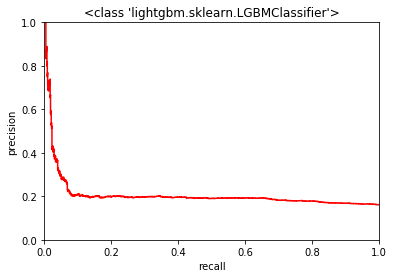

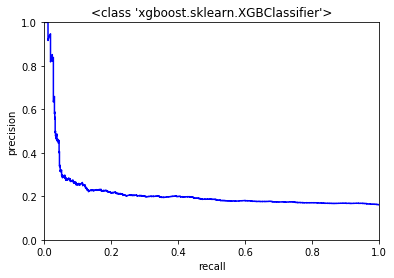

In [49]:
for clf, t, y_prd_prob, c in y_prd_list:
    y_prd = np.where(y_prd_prob[:, 0] < 0.25, 1, 0)
    print(clf.classes_)
    print(y_prd.shape, sum(y_prd))

    print(X_test_full["code"].iloc[y_prd==1])
    # print(X_test_full["code"])

    print("accuracy", metrics.accuracy_score(y_test, y_prd))
    print("precison", metrics.precision_score(y_test, y_prd))
    print("recall", metrics.recall_score(y_test, y_prd))
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_prd_prob[:, 1])

    plt.figure()
    plt.title(clf.__class__)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.plot(recall, precision, color=c)
    print(clf, t)


In [50]:
y_prd = y_prd_list[1][2]
prd_inc = X_test_full[y_prd[:,0]<0.25][["code","f1mv_open",
                                       # "f20max_f1mv_high",
                                       "f19max_f2mv_high"]]
prd_inc["pct"] = prd_inc["f19max_f2mv_high"]/prd_inc["f1mv_open"]-1
prd_inc["y_prd"]=y_prd[:,1][y_prd[:,0]<0.25]

for code, df in prd_inc.groupby(["code"]):
    print(df)
    

                 code  f1mv_open  f19max_f2mv_high       pct     y_prd
2018-04-25  000002.SZ   4160.190          3962.478 -0.047525  0.755439
2018-05-14  000002.SZ   3859.503          3812.821 -0.012095  0.757259
                 code  f1mv_open  f19max_f2mv_high       pct     y_prd
2018-06-25  000063.SZ  203.65230         277.21972  0.361240  0.951405
2018-06-26  000063.SZ  206.96757         277.21972  0.339436  0.950841
2018-06-27  000063.SZ  202.07360         277.21972  0.371875  0.967484
2018-06-28  000063.SZ  206.33609         277.21972  0.343535  0.967498
2018-06-29  000063.SZ  205.70461         277.21972  0.347659  0.968806
2018-07-02  000063.SZ  191.81205         277.21972  0.445267  0.957633
2018-07-03  000063.SZ  212.33515         277.21972  0.305576  0.945221
2018-07-04  000063.SZ  213.12450         277.21972  0.300741  0.981344
2018-07-05  000063.SZ  207.75692         277.21972  0.334347  0.990305
2018-07-06  000063.SZ  207.59905         277.21972  0.335361  0.982108
2018-0

In [ ]:
inc = X_test_full[["code","f1mv_open",
                   "f19max_f2mv_high"]].copy()
inc["pct"] = inc["f19max_f2mv_high"]/inc["f1mv_open"]-1
y0 = inc["pct"].mean()
print(y0)
x0 = np.arange(11)*0.1
y0 = np.ones(x0.shape)*y0
y1 = []
count = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    tmp = inc["pct"][(p0<y_prd[:,1]) & (y_prd[:,1]<p1)]
    y1.append(tmp.mean())
    count.append(len(tmp))

print(count)
plt.bar(np.arange(len(y1))*0.1+0.05,y1,width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

0.08248621903957754


IndexError: too many indices for array

2014-01-02   -0.012346
2014-01-02   -0.005019
2014-01-02    0.016703
2014-01-02    0.100000
2014-01-02    0.017769
2014-01-02    0.019928
2014-01-02   -0.018987
2014-01-02    0.037736
2014-01-02    0.007828
2014-01-02    0.685499
2014-01-02    0.267578
2014-01-02    0.014118
2014-01-02    0.173324
2014-01-02    0.099548
2014-01-02    0.275000
2014-01-02    0.020259
2014-01-02    0.158824
2014-01-02    0.329836
2014-01-02    0.141119
2014-01-02    0.237326
2014-01-02   -0.018634
2014-01-02    0.013825
2014-01-02   -0.002089
2014-01-02   -0.000466
2014-01-02    0.147944
2014-01-02    0.094288
2014-01-02    0.178862
2014-01-02    0.097378
2014-01-02    0.030395
2014-01-02    0.090612
                ...   
2018-08-29    0.072214
2018-08-29    0.016413
2018-08-29   -0.019108
2018-08-29    0.079975
2018-08-29   -0.008950
2018-08-29    0.007974
2018-08-29    0.000000
2018-08-29    0.012737
2018-08-29    0.020188
2018-08-29    0.039495
2018-08-29   -0.027422
2018-08-29   -0.006912
2018-08-29 

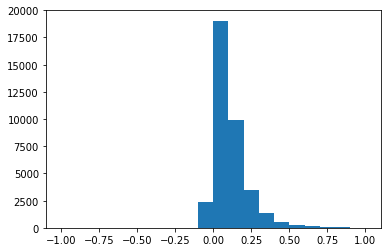

In [62]:
y_reg = gen_y(df_all,pred_period=pred_period,label_type=None)
y_reg = y_reg.dropna()
y_reg_train,y_reg_test = y_reg[~condition],y_reg[condition]

regs = [
    lgbm.LGBMRegressor(n_estimators=300,
                        num_leaves=100, max_depth=8, random_state=0),
    xgb.XGBRegressor(n_estimators=300,
                      max_depth=5,
                      random_state=0),
]

y_prd_list = []
colors = ["r", "b"]
for reg, c in zip(regs, colors):
    t1 = time.time()
    reg.fit(X_train, y_reg_train)
    t2 = time.time()
    y_prd_list.append([reg, t2 - t1, reg.predict(X_test), c])

0.1285935759682332
0.12593603


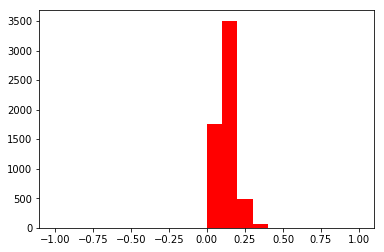

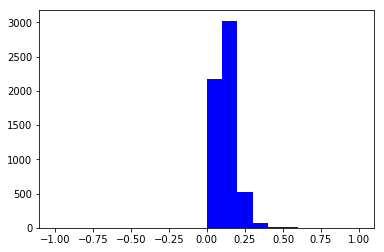

In [63]:
for reg, t, y_prd, c in y_prd_list:
    print(np.mean(y_prd))
    plt.figure()
    plt.hist(y_prd,bins=np.arange(-10,11)*0.1,color=c)

In [77]:
y_prd = y_prd_list[1][2]
prd_inc = X_test_full[y_prd>0.2][["code","f1mv_open",
                                       "f19max_f2mv_high"]]
prd_inc["pct"] = prd_inc["f19max_f2mv_high"]/prd_inc["f1mv_open"]-1
prd_inc["y_prd"]=y_prd[y_prd>0.2]

print(sum(y_prd>0.3))

# y_distribution(pd.Series(y_prd))
# for code, df in prd_inc.groupby(["code"]):
#     print(df)

84


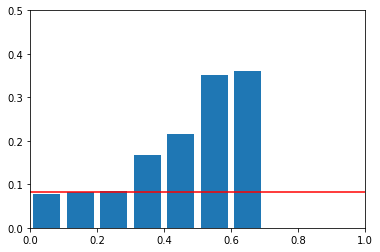

In [78]:
y2 = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    y2.append(inc["pct"][(p0<y_prd) & (y_prd<p1)].mean())

plt.bar(np.arange(len(y2))*0.1+0.05,y2,width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y2,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()